# Project  : Landcover prediction using Deep learning
## Shahab Esfandiar

-------------------------------------------------------------------------------------------------

#### *At first, we should import the required libraries such as Numpy, Tensorflow, Gdal, Matplotlib and so on*

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sb
from PIL import Image
from osgeo import gdal
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import f1_score
from scipy.interpolate import interpn
from skimage.util import view_as_windows
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Conv2D  
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import concatenate, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

-------------------------------------------------------------------------------------------------

## <span style="color:green;">1. Data Prepration</span>

#### *To prepare the dataset for this project, we needed pre-processing which was done using <span style="color:red;">ArcGIS Pro</span>. These pre-processings are respectively :*

>*1. Converting the coordinate system of population density rasters from WGS to Canadian Spatial Reference System.*

>*2. Clipping the above rasters based on the case study area and land cover rasters.*

>*3. Equalizing the pixel size of the rasters with each other and resampling them to 30 meter pixels.*

#### *We did all the above steps in the export data section of the software and by applying the mentioned settings. Since the coordinate system of the population density rasters is based on the land cover raster for export. We fixed the error that occurred when clipping in arcgis software.*

#### *For this reason, the pro version of this software brings us fewer steps and higher accuracy than the previous version.*

-------------------------------------------------------------------------------------------------

#### *In order to prepare the dataset, in the next step, after equalizing their spatial resolution, we must also equalize their temporal resolution.*

#### *For this, we use a linear interpolation using meshgrid. so as to create an approximation using 5 existing rasters for the years 2000 to 2020 and save the approximate rasters. With this, all the spatial requirements for the dataset of this project are provided.*

In [ ]:
Image.MAX_IMAGE_PIXELS = None
output = "D:\GeoAi\Week8\Project\PopDen"

image_2000 = Image.open("D:\GeoAi\Week8\Project\PopulationDensity\p2000.tif")
image_2005 = Image.open("D:\GeoAi\Week8\Project\PopulationDensity\p2005.tif")
image_2010 = Image.open("D:\GeoAi\Week8\Project\PopulationDensity\p2010.tif")
image_2015 = Image.open("D:\GeoAi\Week8\Project\PopulationDensity\p2015.tif")
image_2020 = Image.open("D:\GeoAi\Week8\Project\PopulationDensity\p2020.tif")

arr = np.r_['0,3', image_2000, image_2005, image_2010, image_2015, image_2020]
slices, rows, cols = arr.shape

#Create meshgrid
[X, Y, Z] = np.meshgrid(np.arange(cols), np.arange(rows), np.arange(slices))

if not os.path.exists(output):
    os.makedirs(output)

for year in range(2001, 2020):
    
    #Determination of weights
    [X2, Y2, Z2] = np.meshgrid(np.arange(cols), np.arange(rows), [(year - 2000) / 20 * 4])
    Vi = interpn((X, Y, Z), arr, np.array([X2, Y2, Z2]).T)

    plt.imshow(Vi[0], cmap=plt.cm.gray)
    plt.savefig(os.path.join(output, f"p{year}.tif"))
    

-------------------------------------------------------------------------------------------------

#### *Now we need to define our data format as specified for this project. Therefore, with the following code snippet, we will create the required folders for data storage for the years 2000 to 2020.*

In [3]:
path = "D:\Learning\GeoAi\Week8\Data\Train"

for i in range(2001, 2020):
    folder_name = "y" + str(i)
    new_path = os.path.join(path, folder_name)
    os.makedirs(new_path)

    try:
        os.makedirs(new_path)

    except FileExistsError:
        pass


-------------------------------------------------------------------------------------------------

#### *At this stage, we need to extract the patch from the raster images of each year. Since the dimensions of the images are large, we convert each raster into a number of smaller 64 x 64 non-overlapping rasters.*

#### *Then we have to remove the negative or nan values from our data and finally save the patches as two-dimensional arrays in the folder corresponding to each year. Also, since we have to use the data of 2019 as a test of our prediction model, we store its arrays in a separate path.*

#### *After completing the above steps, pre-processing is needed. First of all, we have to encode the land cover data and convert it into 11 bands so that the model does not make mistakes in learning. Then we have to save all the arrays in Float32 format so that the required storage space is less.*

In [ ]:
input_pop_dir = "D:\\Learning\\GeoAi\\Week8\\Data\\PopDen"
input_lc_dir = "D:\\Learning\\GeoAi\\Week8\\Data\\LandCover"
output_dir = "D:\\Learning\\GeoAi\\Week8\\Data\\Train"

# Patch size and step for sliding window
patch_size = (64, 64) 
patch_step = 64
c = 2001

# Loop through each year from 2001 to 2019
for year in range(2001, 2020):

    # Construct file paths for population density and land cover data
    input_pop_file = os.path.join(input_pop_dir, f"p{year}.tif") 
    input_lc_file = os.path.join(input_lc_dir, f"LC{year}.tif") 
    output_subdir = os.path.join(output_dir, f"y{year}") 
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)
    
    # Open raster files
    rasterPop_image = gdal.Open(input_pop_file)
    rasterLC_image = gdal.Open(input_lc_file)
    
    # Read raster data as arrays
    rasterPop_array = rasterPop_image.ReadAsArray()
    rasterLC_array = rasterLC_image.ReadAsArray()

    # Handle no-data values in population density array
    rasterPop_array[rasterPop_array < 0] = np.nan
    col_mean_Pop = np.nanmean(rasterPop_array, axis=0)
    index_Pop = np.where(np.isnan(rasterPop_array))
    rasterPop_array[index_Pop] = np.take(col_mean_Pop, index_Pop[1])
    
    # Extract patches using sliding window
    pop_patches = view_as_windows(rasterPop_array, patch_size, step=patch_step) 
    lc_patches = view_as_windows(rasterLC_array, patch_size, step=patch_step) 
    
    num_x = pop_patches.shape[0]
    num_y = pop_patches.shape[1] 
    val = list(np.unique(rasterLC_array))
    
    # Loop through each patch
    for i in range(num_x):
        for j in range(num_y):
            
            # Construct output file path
            output_file = os.path.join(output_subdir, f"arr{year}_{i}_{j}.npz") 
            pop_patch = pop_patches[i, j] 
            lc_patch = lc_patches[i, j] 

            # One-hot encode land cover data
            x, y = lc_patch.shape
            lc = np.zeros((x, y, 11), dtype=np.float32)

            for k in range(11):
                if np.sum(lc_patch == val[k]) > 0:
                    X, Y = np.where(lc_patch == val[k])
                    lc[X, Y, k] = 1

            # Save patches as compressed .npz files
            pop_patch = pop_patch.astype(np.float32)
            lc = lc.astype(np.float32)
            arr = np.concatenate((lc, pop_patch[..., np.newaxis]), axis=2)
            arr = arr.astype(np.float32)
            np.savez_compressed(output_file, arr=arr)

    print(f"Processed y{c}")
    c += 1
            

-------------------------------------------------------------------------------------------------

## <span style="color:green;">2. Data Preprocessing</span>

#### *With the completion of data preparation and pre-processing steps, it is time to create data in time series format according to the model and <span style="color:red;">CNN-GRU</span> selected for this project.*

In [ ]:
# Parameters for the data dimensions and time steps
num_patches = 2500
time_step, width, height, channel = 4, 64, 64, 12
num_years = 19
u = 0
co = 1

# Loop through each patch grid (50x50)
for i in range(50):
    for j in range(50):
        c = 1
        
        # Loop through each year minus the time step
        for k in range(num_years - time_step):
            # Load the first array for the current year
            first_array = np.load(os.path.join("D:\\Learning\\GeoAi\\Week8\\Data\\Train", f"y{2001+k}", f"arr{2001+k}_{i}_{j}.npz"))['arr']
            assert first_array.shape == (width, height, channel)
            next_arrays = []
            
            # Load subsequent arrays for the time steps
            for z in range(1, time_step + 1):
                a = np.load(os.path.join("D:\\Learning\\GeoAi\\Week8\\Data\\Train", f"y{2001+k+z}", f"arr{2001+k+z}_{i}_{j}.npz"))['arr']
                next_arrays.append(a)
            
            # Ensure all arrays have the correct shape
            for array in next_arrays:
                assert array.shape == (width, height, channel)
        
            # Stack the arrays to create the input data
            input = np.stack([first_array] + next_arrays[:-1], axis=0)
            input = input.astype(np.float32)
            np.savez_compressed(os.path.join("D:\\Learning\\GeoAi\\Week8\\Project\\Train\\Input", f"input_{u}.npz"), input=input)
            
            # Prepare the label data by removing the last channel
            label_train = np.delete(next_arrays[-1], -1, axis=2)
            label_train = label_train.astype(np.float32)
            np.savez_compressed(os.path.join("D:\\Learning\\GeoAi\\Week8\\Project\\Train\\Label", f"label_{u}.npz"), label=label_train)
            
            # Print progress
            print(f"Processed sample {c} of patch {co} out of {num_patches}")
            c += 1
            u += 1
            
        co += 1


-------------------------------------------------------------------------------------------------

#### *Now we need to separate the last 2500 arrays related to the year 2019 from the data and save them in another folder with a suitable name.*

In [51]:
test_path = "D:\Learning\GeoAi\Week8\Project\Test"

for folder in ["input", "label"]:
    folder_path = os.path.join(test_path, folder)

    for file in os.listdir(folder_path):
        
        file_number = int(file.split("_")[1].split(".")[0])
        new_name = f"{folder}_{file_number - 35000}.npz"
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, new_name))
        

-------------------------------------------------------------------------------------------------

#### *Next, we should define the directory path for training/test data and list files in that directory.*

In [20]:
input_loc_train = "D:\Learning\GeoAi\Week8\Project\Train\Input"
input_files_train = os.listdir(input_loc_train)

label_loc_train = "D:\Learning\GeoAi\Week8\Project\Train\Label"
label_files_train = os.listdir(label_loc_train)

input_loc_test = "D:\Learning\GeoAi\Week8\Project\Test\Input"
input_files_test = os.listdir(input_loc_test)

label_loc_test = "D:\Learning\GeoAi\Week8\Project\Test\Label"
label_files_test = os.listdir(label_loc_test)

# Create a dictionary to map input file names to corresponding label file names for training/test data
image_label_map = {"input_{}.npz".format(i): "label_{}.npz".format(i)
                    for i in range(len(input_files_train))}

image_label_map_val = {"input_{}.npz".format(i): "label_{}.npz".format(i)
                       for i in range(len(input_files_test))}


-------------------------------------------------------------------------------------------------

#### *Now we need to create two <span style="color:red;">Data Generator</span> classes to avoid memory errors. Because we have a very large number of samples and the gpu memory is not capable of processing this amount of data. As a result, by using this class, we give the data to the model in the form of 4 so that our graphic memory has the capacity to process it.*

In [36]:
time_step, width, height, channel = 4, 64, 64, 12

# Define a custom data generator class for training/test data
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_examples, batch_size = 4, dim = (time_step, width, height, channel), shuffle = True):
        # Constructor of the data generator.
        self.dim = dim
        self.batch_size = batch_size
        self.list_examples = list_examples
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.list_examples) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_examples[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        # This function is called at the end of each epoch.
        self.indexes = np.arange(len(self.list_examples))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Load individual numpy arrays and aggregate them into a batch.

        X = np.empty([self.batch_size, self.dim[0], self.dim[1], self.dim[2], self.dim[3]], dtype = np.float32)

        # y is a one-hot encoded vector.
        y = np.empty([self.batch_size, width, height, 11], dtype = np.float32)

        # Generate data.

        c = 0
        for i in list_IDs_temp:

            x_file_path = os.path.join(input_loc_train, i)
            y_file_path = os.path.join(label_loc_train, image_label_map.get(i))

            # Load sample
            X[c, :, :, :, :] = np.load(x_file_path)['input']
            
            # Load labels    
            y[c, :, :, :] = np.load(y_file_path)['label']
            

            c += 1

        return X, y


In [ ]:
class ValDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_examples, batch_size = 4, dim = (time_step, width, height, channel), shuffle = True):
        # Constructor of the data generator.
        self.dim = dim
        self.batch_size = batch_size
        self.list_examples = list_examples
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.list_examples) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_examples[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        # This function is called at the end of each epoch.
        self.indexes = np.arange(len(self.list_examples))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Load individual numpy arrays and aggregate them into a batch.

        X = np.empty([self.batch_size, self.dim[0], self.dim[1], self.dim[2], self.dim[3]], dtype = np.float32)

        # y is a one-hot encoded vector.
        y = np.empty([self.batch_size, width, height, 11], dtype = np.float32)

        # Generate data.

        c = 0
        for i in list_IDs_temp:

            x_file_path = os.path.join(input_loc_test, i)
            y_file_path = os.path.join(label_loc_test, image_label_map_val.get(i))

            # Load sample
            X[c, :, :, :, :] = np.load(x_file_path)['input_train']
            # Load labels     
            y[c, :, :, :] = np.load(y_file_path)['label_train']

            c += 1

        return X, y


In [37]:
# Create instances of the custom data generators for training and validation data
training_generator = DataGenerator(input_files_train)
validation_generator = ValDataGenerator(input_files_test)

-------------------------------------------------------------------------------------------------

## <span style="color:green;">3. Model</span>

#### *Then we come to the architectural design of our model.  <span style="color:red;">Deeplab V3</span> architecture is used in this model and some changes have been applied to it.*

#### *Since the data used in this project is a time series. Time distributed convolutional layers are used so that the model has the ability to understand time and the extracted features are also in terms of time. We also added a regularization kernel to adding penalty factors to the network layers to alter the weight propagation through the layers which facilitate the model to converge optimally. In addition, max pooling and <span style="color:red;">CNN</span> layers with different dilation_rate are used to extract features with different and better dimensions and to reduce the amount of data*.

#### *After the CNN layers and their normalization by Batch Normalization, it is the turn of the <span style="color:red;">GRU</span> layers to form the hybrid architecture we need. These layers, like RNN layers, can model the time step. Finally, by adding a few Dense and dropout layers to avoid overfitting the model, we complete the computational part of the model and add the output layer with 11 neurons to recognize the 11 classes in the land cover rasters in binary form.*

In [23]:
regularizer=keras.regularizers.l2(1e-2)
ALPHA = 0.8
BETA = 0.2

In [24]:
def CNN_GRU_Model(input_shape):
    """
    Creates a CNN-GRU model for spatiotemporal data processing.

    Parameters:
    input_shape (tuple): Shape of the input data (time_steps, width, height, channels).

    Returns:
    model (tf.keras.Model): Compiled CNN-GRU model.
    """
    
    # Define the input layer with the given shape
    inputs = tf.keras.Input(shape=input_shape) 
    
    # First convolutional block with TimeDistributed layers
    x = TimeDistributed(Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizer))(inputs) 
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x) 
    
    # Second convolutional block
    x = TimeDistributed(Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizer))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x) 

    # Atrous (dilated) convolutions for multi-scale context aggregation
    x2 = TimeDistributed(Conv2D(64, (3,3), dilation_rate=3, activation='relu', padding='same', kernel_regularizer=regularizer))(x)
    x3 = TimeDistributed(Conv2D(64, (3,3), dilation_rate=6, activation='relu', padding='same', kernel_regularizer=regularizer))(x)    
    x4 = TimeDistributed(Conv2D(64, (3,3), dilation_rate=12, activation='relu', padding='same', kernel_regularizer=regularizer))(x)
    x5 = TimeDistributed(Conv2D(64, (3,3), dilation_rate=18, activation='relu', padding='same', kernel_regularizer=regularizer))(x)
    x6 = TimeDistributed(Conv2D(64, (3,3), dilation_rate=24, activation='relu', padding='same', kernel_regularizer=regularizer))(x)  
    
    # Concatenate the outputs of the atrous convolutions
    x6 = concatenate([x6, x5, x2, x3, x4])
    
    # Additional convolutional layers
    x7 = TimeDistributed(Conv2D(32, (1,1), padding='same', kernel_regularizer=regularizer))(x6) 
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x7)
    x = TimeDistributed(Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizer))(x) 
    x = TimeDistributed(Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizer))(x) 
    x = TimeDistributed(BatchNormalization())(x) 
    x = TimeDistributed(Flatten())(x) 
    
    # GRU layers for temporal processing
    x = GRU(64, return_sequences=True)(x) 
    x = GRU(64)(x) 

    # Fully connected layers with Dropout
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x) 
    x = Dropout(rate=0.3)(x)
    
    # Output layer with sigmoid activation and reshaping to the desired output shape
    outputs = Dense(64*64*11, activation='sigmoid')(x) 
    outputs = Reshape((64, 64, 11))(outputs) 

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


-------------------------------------------------------------------------------------------------

### *Here we create two functions to calculate the confusion matrix, TverskyLoss, jac_distance and F1 score to use them for loss functios and evaluate our model.*

In [25]:
def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
    """
    Computes the Tversky loss for image segmentation tasks.

    The Tversky loss is a generalization of the Dice coefficient, which allows for 
    asymmetric penalties for false positives and false negatives. This can be useful 
    in medical image segmentation where the cost of false positives and false negatives 
    may differ.

    Parameters:
    targets (tensor): Ground truth binary masks.
    inputs (tensor): Predicted binary masks.
    alpha (float): Weight of false positives.
    beta (float): Weight of false negatives.
    smooth (float): Smoothing factor to avoid division by zero.

    Returns:
    float: Tversky loss value.
    """
    
    # Flatten the input and target tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    # Calculate true positives, false positives, and false negatives
    TP = K.sum((inputs * targets))
    FP = K.sum(((1 - targets) * inputs))
    FN = K.sum((targets * (1 - inputs)))
    
    # Compute the Tversky index
    Tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)

    # Return the Tversky loss
    return (1 - Tversky)
    

In [26]:
def iou(y_true, y_pred, smooth=1):
    """
    Computes the Intersection over Union (IoU) metric.

    The IoU metric, also known as the Jaccard index, is used to evaluate the 
    similarity between two sets, typically used for image segmentation tasks.

    Parameters:
    y_true (tensor): Ground truth binary masks.
    y_pred (tensor): Predicted binary masks.
    smooth (float): Smoothing factor to avoid division by zero.

    Returns:
    float: IoU value.
    """
    # Calculate the intersection and union of the true and predicted masks
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    
    # Compute the IoU
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return jac

def jac_distance(y_true, y_pred):
    """
    Computes the Jaccard distance, which is the complement of the IoU.

    The Jaccard distance is used as a loss function for training segmentation models.

    Parameters:
    y_true (tensor): Ground truth binary masks.
    y_pred (tensor): Predicted binary masks.

    Returns:
    float: Jaccard distance value.
    """
    # Flatten the input tensors
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    
    # Return the negative IoU as the Jaccard distance
    return -iou(y_true, y_pred)
    

In [27]:
def confusion_matrix(label, predict):
    """
    Computes the confusion matrix for binary classification tasks.

    The confusion matrix is a table that is often used to describe the performance 
    of a classification model. It contains the counts of true positives, true negatives, 
    false positives, and false negatives.

    Parameters:
    label (tensor): Ground truth binary labels.
    predict (tensor): Predicted binary labels.

    Returns:
    np.array: 2x2 confusion matrix.
    """
    
    # Reshape the labels and predictions to 1D tensors
    label = tf.reshape(label, [-1])
    predict = tf.reshape(predict, [-1])

    # Cast the labels and predictions to boolean
    label = tf.cast(label, tf.bool)
    predict = tf.cast(predict, tf.bool)
    
    # Calculate true positives, true negatives, false positives, and false negatives
    true_positive = tf.reduce_sum(tf.cast(tf.logical_and(label, predict), tf.int32))
    true_negative = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(label), tf.logical_not(predict)), tf.int32))
    false_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(label), predict), tf.int32))
    false_negative = tf.reduce_sum(tf.cast(tf.logical_and(label, tf.logical_not(predict)), tf.int32))
    
    # Return the confusion matrix as a numpy array
    return np.array([[true_positive, false_positive], [false_negative, true_negative]])
    

In [49]:
def F1_score(y_true, y_pred):
    """
    Computes the F1 score for binary classification tasks.

    The F1 score is the harmonic mean of precision and recall, providing a balance 
    between the two. It is especially useful for imbalanced datasets.

    Parameters:
    y_true (tensor): Ground truth binary labels.
    y_pred (tensor): Predicted binary labels.

    Returns:
    float: F1 score value.
    """
    
    # Calculate precision and recall
    precision = Precision()(y_true, y_pred)
    recall = Recall()(y_true, y_pred)
    
    # Compute the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1_score
    

-------------------------------------------------------------------------------------------------

### *Next, we can create an instance of the custom neural network model with the specified input shape.Then we compile the model using the precision and recall criteria and the <span style="color:red;">binary_crossentropy</span> loss function. We also add 2 callbacks to save the best model.*

In [29]:
# Define the model with the given input shape
model = CNN_GRU_Model((time_step, width, height, channel))

# Define the Hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss = TverskyLoss, optimizer = optimizer, metrics = [Recall(), Precision(), jac_distance])
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25)

callbacks = [ModelCheckpoint("D:/Learning/GeoAi/Week8/Project/BestModel.h5",
                             verbose = 1, save_best_only = True), early_stopping]

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 64, 64, 1 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 4, 62, 62, 12 13952       input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 4, 31, 31, 12 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 4, 29, 29, 25 295168      time_distributed_1[0][0]         
______________________________________________________________________________________________

-------------------------------------------------------------------------------------------------

### *Now we fit the created model on our training data with 20 epochs and after finishing the training process of the model, we save the best epoch.*

In [156]:
history = model.fit(training_generator, epochs = 20, validation_data = validation_generator, callbacks = callbacks)

Epoch 1/20
8750/8750 [==============================] - 829s 95ms/step - loss: 0.6221 - recall_6: 0.3886 - precision_6: 0.3758 - jac_distance: -0.2467 - val_loss: 0.5485 - val_recall_6: 0.4614 - val_precision_6: 0.4497 - val_jac_distance: -0.3059

Epoch 00001: val_loss did not improve from 0.54849
Epoch 2/20
8750/8750 [==============================] - 810s 93ms/step - loss: 0.6221 - recall_6: 0.3886 - precision_6: 0.3758 - jac_distance: -0.2463 - val_loss: 0.5485 - val_recall_6: 0.4614 - val_precision_6: 0.4497 - val_jac_distance: -0.3052

Epoch 00002: val_loss improved from 0.54849 to 0.54848, saving model to D:/Learning/GeoAi/Week8/Project\BestModel.h5
Epoch 3/20
8750/8750 [==============================] - 797s 91ms/step - loss: 0.6221 - recall_6: 0.3886 - precision_6: 0.3758 - jac_distance: -0.2465 - val_loss: 0.5485 - val_recall_6: 0.4614 - val_precision_6: 0.4497 - val_jac_distance: -0.3071

Epoch 00003: val_loss did not improve from 0.54848
Epoch 4/20
8750/8750 [===============

-------------------------------------------------------------------------------------------------

## <span style="color:green;">4. Evaluation</span>

### *Next, we load the best model for predict the test data and evaluate it based on the mentioned criteria.*

In [34]:
MyModel = load_model("D:\Learning\GeoAi\Week8\Project\BestModel.h5", custom_objects = {'TverskyLoss':TverskyLoss, 'jac_distance':jac_distance})

In [38]:
label_pred = MyModel.predict(validation_generator)

In [39]:
MyModel.evaluate(validation_generator)

625/625 [==============================] - 11s 15ms/step - loss: 0.5485 - recall_6: 0.4614 - precision_6: 0.4497 - jac_distance: -0.3056


[0.5485276579856873,
 0.4614284634590149,
 0.44965338706970215,
 -0.3055548071861267]

-------------------------------------------------------------------------------------------------

### *In the following, the <span style="color:red;">sigmoid</span> activator outputs the values as numbers between 0 and 1. We create a threshold on the output data so that each element becomes 0 or 1.*

In [40]:
condition = label_pred > 0.5
label_pred = np.where(condition, 1, 0)

-------------------------------------------------------------------------------------------------

### *Now we create a matrix to cover all the project data using the stored arrays.*

In [81]:
# Initialize lists to store input and label arrays
input_list = []
label_list = []

# Get the number of files in the input directory
num_files = len(os.listdir("D:\\Learning\\GeoAi\\Week8\\Project\\Test\\Input"))

# Loop through each file index
for i in range(num_files):
   
    input_file = "D:\\Learning\\GeoAi\\Week8\\Project\\Test\\Input\\input_" + str(i) + '.npz'
    label_file = "D:\\Learning\\GeoAi\\Week8\\Project\\Test\\Label\\label_" + str(i) + '.npz'
    
    # Load the input and label arrays from the .npz files
    input_array = np.load(input_file)['input_train']
    label_array = np.load(label_file)['label_train']
    
    # Append the arrays to the respective lists
    input_list.append(input_array)
    label_list.append(label_array)

# Stack the lists into 5D and 4D arrays respectively
input_5D = np.stack(input_list, axis=0)
label_4D = np.stack(label_list, axis=0)

-------------------------------------------------------------------------------------------------

### *Then we come to evaluations of confusion matrix and F1 score.*

In [42]:
total_confusion_matrix = np.zeros((2, 2))

for i in range(2500):
    total_confusion_matrix += confusion_matrix(label_4D[i], label_pred[i])

total_confusion_matrix = pd.DataFrame(total_confusion_matrix, index=['True', 'False'], columns=['Positive', 'Negative'])
total_confusion_matrix

,Positive,Negative
True,4614568.0,5647932.0
False,5386046.0,96991454.0


-------------------------------------------------------------------------------------------------

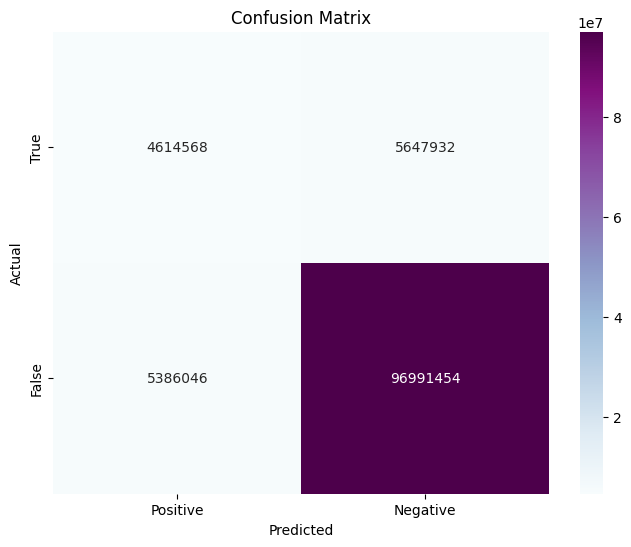

In [44]:
# Plot the dataframe as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sb.heatmap(total_confusion_matrix, annot=True, fmt='.0f', cmap="BuPu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

-------------------------------------------------------------------------------------------------

In [ ]:
f1_scores = []

for i in range(2500):
    label = label_4D[i].flatten()
    predict = label_pred[i].flatten()
    f1 = f1_score(label, predict)
    f1_scores.append(f1)
    

In [62]:
mean_f1_score = (sum(f1_scores)/len(f1_scores))
print('F1 Score : ', mean_f1_score)

F1 Score :  0.4502526237820023


-------------------------------------------------------------------------------------------------

### *Now, we randomly select 5 patches for decoding to visually compare the predicted map with the initial map.*

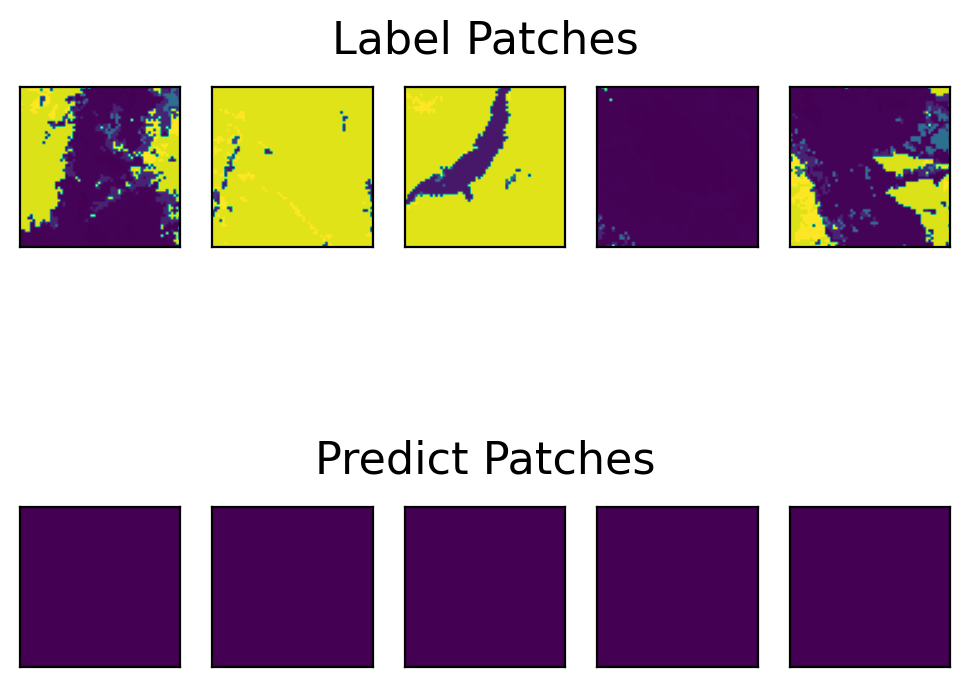

In [176]:
# Define the class values for the land cover types
val = [20, 31, 32, 33, 50, 80, 81, 100, 210, 220, 230]

# Initialize lists to store the final predicted and label maps
final_pred = []
final_label = []

# Loop to generate and visualize 5 random samples
for j in range(5):
    
    # Initialize empty maps for predictions and labels
    final_map_pred = np.zeros((64, 64), dtype=np.float32)
    final_map_label = np.zeros((64, 64), dtype=np.float32)
    
    # Select a random sample index
    k = np.random.randint(0, 2499)
    print(k)
    
    # Map the predicted and label values to the final maps
    for i in range(11):
        x, y = np.where(label_pred[k, :, :, i] == 1)
        final_map_pred[x, y] = val[i]
        
        u, v = np.where(label_4D[k, :, :, i] == 1)
        final_map_label[u, v] = val[i] 
        
    # Append the final maps to the lists
    final_pred.append(final_map_pred)
    final_label.append(final_map_label)

fig, axes = plt.subplots(2, 5, figsize=(6, 5), dpi=200)

# Set titles for the label and prediction rows
axes[0, 2].set_title("Label Patches", fontsize=16, y=1.1)
axes[1, 2].set_title("Predict Patches", fontsize=16, y=1.1)

# Loop to display the label and prediction maps
for i in range(5):
    axes[0, i].imshow(final_label[i], cmap='viridis')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    
    axes[1, i].imshow(final_pred[i], cmap='viridis')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

plt.show()

-------------------------------------------------------------------------------------------------

### *As we can see, by examining the random patches, we find that the model has made most of the patches belong to the class with a value 210. This problem of low accuracy of the model can be due to the complexity of the data pattern, which makes the model with 20 epochs not understand it. Therefore, to improve the accuracy of this model, the number of epochs can be increased, or more data can be used to train the model. Also, the selection of the Loss function can have a favorable effect on the prediction result.*

# END ^^